# Simulating a Double Pendulum with Lagrangian Mechanics

The double pendulum is the classical example of a chaotic system, one that is sensitive to initial conditions. In this notebook, we use sympy, and scipy to develop and simulate a double pendulum model. The double pendulum is a complex system with many dynamic forces that act on it. So, we will be using something called Lagrangian mechanics to find the equations of motion of the double pendulum



We'll be simulating the pendulum with no atmospheric drag for now.

We first determine the lagrangian. Lagrangian is defined by difference between Kinetic energy ($T$) and Potential energy ($V$). Loosely, the lagrangian defines the state of the energy in the system (either completely positive for all kinetic energy or completely negative for all potential energy)

$$
L = T - V
$$

We feed this quantity into the Euler-Lagrange equation and solve for the free variables in order to get the equations of motion

$$
\frac{\partial L}{\partial q_i} = \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q_i}} \right)
$$

Where $q_i$ are the generalized coordinates of the system, which in our case are $\theta_1$ and $\theta_2$

What we'll do first is construct the lagrangian formula based on the $x_1$, $y_1$, $x_2$, and $y_2$ coordinates respectively, defined in the diagram above. And then substitute these coordinates with their representation in $\theta$ coordinates.

Since the equations can get unruly, we will get some help from the `sympy` library to construct and solve our equations

In [113]:
import scipy.integrate as spi
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
sp.init_printing()
import sympy.physics.mechanics as spm
spm.init_vprinting()


def equation(symbol, output):
    """
    Helper function for displaying equations
    """
    return display(sp.Eq(sp.S(symbol), output))

First we derive our equations using our $x$ and $y$ coordinates.

In [114]:
g, m1, L1, m2, L2 = sp.symbols('g m_1 L_1 m_2 L_2')              # Constants
t = sp.symbols('t')                                              # Time of system
x1, x2, y1, y2 = spm.dynamicsymbols('x_1 x_2 y_1 y_2')           # X,Y Coordinates
x1d, x2d, y1d, y2d = tuple( s.diff() for s in (x1, x2, y1, y2) ) # X,Y Derivatives

Our potential energy formula is related to the height $h$ of each mass.

$$
V = gm_1 h_1 + gm_2 h_2
$$

$h_1$ can be calculated from $y_1$, according to the graphic. $y_1$ is measured from the top down, with the minimum being $0$ and the maximum being $L_1$. All in all, $h_1$ can be defined as $L_1 - y_1$.

We might do something similar for $h_2$. However, in this case, the height of the second mass is also dependent on the height of the first, since they're both connected. So, we'll need to sum both contributions for our $h_2$ equation, giving $L_1 - y_1 + L_2 - y_2$. Our final potential energy equation becomes:

$$
V = g m_1 (L_1 - y_1) + g m_2 (L_1 - y_1 + L_2 - y_2)
$$

We can rearrange this to make things better for us (and `sympy`), by rearranging the equation in terms of $L_1 - y_1$ and $L_2 - y_2$

$$
V = g (m_1 + m_2) (L_1 - y_1) + g m_2 (L_2 - y_2)
$$

We can read this as the first height adds to the potential energy of both masses in the system, since it's lifting both masses by the same height.

In [115]:
# Potential Energy Formula
V = (m1 + m2)*g*(L1 - y1) + m2*g*(L2 - y2)
equation('V', V)

Next our kinetic energy formula. The kinetic energy is proportional to the square of the magnitude of velocity $v$.

$$
T = \frac{ m ||v||^2 }{ 2 }
$$

The quantity $||v||^2$ can be broken down into a sum of squares of changes in it's coordinates (via the pythagorean theorem) 

$$
||\dot{r}||^2 = \dot{x}^2 + \dot{y}^2
$$

Our kinetic energy then becomes the sum of this formula applied to each mass. However, like with potential energy, special consideration has to be given to the second mass since it depends on the motion of the first mass. The only thing that needs to change is that the total velocity of the second mass can be broken into the change in the $x_2, y_2$ coordinates added to the change in the $x_1, y_1$ coordinates.

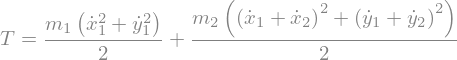

In [116]:
# Kinetic Energy Formula
half = sp.Rational(1,2)
T = half*m1*(x1.diff()**2 + y1.diff()**2) + half*m2*((x1.diff() + x2.diff())**2 + (y1.diff() + y2.diff())**2)
equation('T', T)

Finally, putting both these equations in the Lagrangian gives us the following

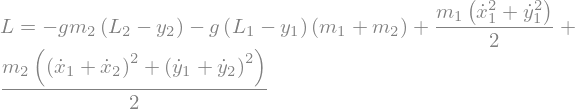

In [117]:
# Lagrangian Formula
L = T - V
equation('L', L)

Next we substitute our coordinates with $\theta_1$ and $\theta_2$ using conversion formulas

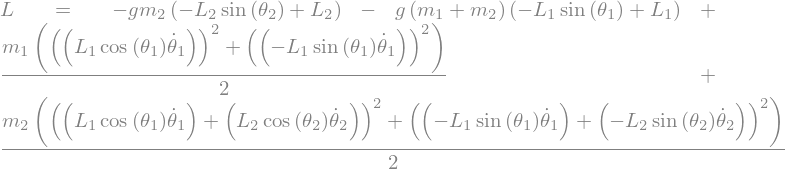

In [118]:
th1, th2 = spm.dynamicsymbols('\\theta_1 \\theta_2') # Theta coordiates
th1d = th1.diff()
th2d = th2.diff()

# Substitution
Lth = L.subs({
    x1: L1*sp.cos(th1),
    x2: L2*sp.cos(th2),
    y1: L1*sp.sin(th1),
    y2: L2*sp.sin(th2)
})
equation('L', Lth)

Finally, we can use trig identities to simplify a whole lot of this

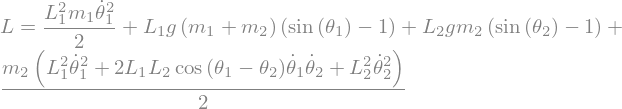

In [119]:
Lth = Lth.simplify().trigsimp()
equation('L', Lth)

Now we construct our differential equations

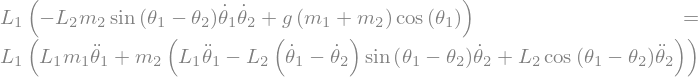

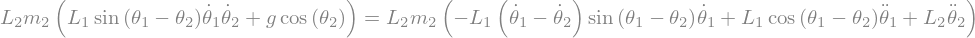

In [132]:
Eq1 = sp.Eq(Lth.diff(th1.diff()).diff(t), Lth.diff(th1)).simplify()
Eq2 = sp.Eq(Lth.diff(th2.diff()).diff(t), Lth.diff(th2)).simplify()
display(Eq1)
display(Eq2)

And finally, solve for $\ddot{\theta}$

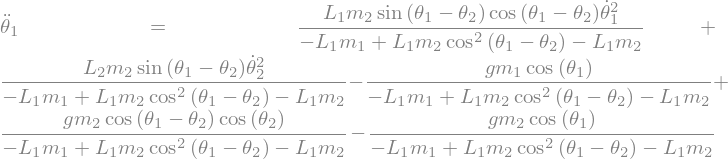

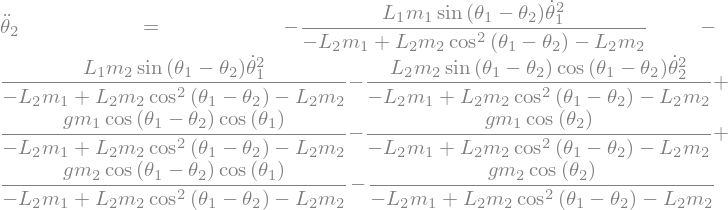

In [144]:
th1dd = th1.diff(t,t)
th2dd = th2.diff(t,t)
Thdd = sp.solve([Eq1, Eq2], [th1dd, th2dd], dict=True)[0]
display(sp.Eq(th1dd, Thdd[th1dd]))
display(sp.Eq(th2dd, Thdd[th2dd]))

So finally, we come to our equation, and we'll build a python class to help with numerical solutions

In [199]:
# Universal gravitational constant
gValue = 9.81
Thdd[th1dd] = Thdd[th1dd].subs(g, gValue)
Thdd[th2dd] = Thdd[th2dd].subs(g, gValue)

class DoublePendulum:
    def __init__(self, m1V, L1V, m2V, L2V):
        self.m1 = m1V
        self.m2 = m2V
        self.L1 = L1V
        self.L2 = L2V
        self._subdict = { m1: self.m1, L1: self.L1, m2: self.m2, L2: self.L2 }
        self._Th1ddS = Thdd[th1dd].subs(self._subdict)
        self._Th1ddF = sp.lambdify([th1, th2, th1d, th2d], self._Th1ddS)
        self._Th2ddS = Thdd[th2dd].subs(self._subdict)
        self._Th2ddF = sp.lambdify([th1, th2, th1d, th2d], self._Th2ddS)
        
    def __call__(self, t, Th):
        th1, th2, om1, om2 = Th
        return np.array([
            om1,
            om2,
            self._Th1ddF(th1, th2, om1, om2),
            self._Th2ddF(th1, th2, om1, om2)
        ])
    
    @property
    def limits(self):
        L = self.L1 + self.L2
        return {
            'x': (-L, L),
            'y': (-2, L + 2)
        }

Since this system is pretty complicated, it can be hard to visualize using a phase plot, but we can run simulations. The double pendulum in particular is used to show how slight changes in initial conditions can result in dramatically different paths the system can take

In [200]:
# Pendulum instance
pendulum = DoublePendulum(2, 2, 3, 4)

# Time parameters
T = [0, 100]
dt_max = 0.1

# Slightly different initial conditions
ThI1 = [ np.pi/4, 0.001, 0, 0 ]
ThI2 = [ np.pi/4, 0.002, 0, 0 ]
ThI3 = [ np.pi/4 + 0.001, 0.003, 0, 0 ]

# Solve for both initial conditions
solution1 = spi.solve_ivp(pendulum, [0, 100], ThI1, max_step=dt_max)
solution2 = spi.solve_ivp(pendulum, [0, 100], ThI2, max_step=dt_max)
solution3 = spi.solve_ivp(pendulum, [0, 100], ThI3, max_step=dt_max)

# Convert system to x and y coordinates
Lv = np.array([pendulum.L1, pendulum.L2])
Th1 = solution1.y[0:2,:]
Th2 = solution2.y[0:2,:]
Th3 = solution3.y[0:2,:]
x1 = np.dot(Lv, np.cos(Th1))
y1 = np.dot(Lv, 1 - np.sin(Th1))
x2 = np.dot(Lv, np.cos(Th2))
y2 = np.dot(Lv, 1 - np.sin(Th2))
x3 = np.dot(Lv, np.cos(Th3))
y3 = np.dot(Lv, 1 - np.sin(Th3))

# Build animation
size = 8, 6
trail_length = 50
fig = plt.figure(figsize=size)
axes = plt.axes(xlim=pendulum.limits['x'], ylim=pendulum.limits['y'])
plt.xticks([])
plt.yticks([])
line1, = axes.plot([], [])
line2, = axes.plot([], [])
line3, = axes.plot([], [])
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return [line1, line2, line3]
def animate(i):
    j = max(i - trail_length, 0)
    line1.set_data(x1[j:i], y1[j:i])
    line2.set_data(x2[j:i], y2[j:i])
    line3.set_data(x3[j:i], y3[j:i])
    return [line1, line2, line3]
animation = anim.FuncAnimation(
    fig, animate, init_func=init,
    frames=x.shape[0], interval=20, blit=True)
plt.close(fig)
HTML(animation.to_html5_video())